# Data Wrangling - Insurance App Ratings on Google Play Store

Th objective of this project is to leverage GI companies apps' Play Store reviews to analyze customers' feedback to know what is working, what are the challenges and how companies can address those challenges. The main focus of our analysis is extracting information from negative sentiment & providing actionable insights on improving customer experience to GI comapnies.

In this notebook, we will explore the data for
1. __Completeness__ : Each record contains all the variables and records are unique.
2. __Validity__ : We will be focusing on reviews in the English language.
3. __Credibility__ : Do we have relevant and enough information in review text ?
4. __Cleaning__ : Accordingly, we will perform typical data cleaning steps.

The data is scraped from the Play Store as at 26 Aug 2021. Details are in Data_Scraping notebook.

In [1]:
import pandas as pd
import numpy as np
import time
import string
from datetime import datetime
from pathlib import Path
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from contractions import CONTRACTION_MAP
import unicodedata
from spellchecker import SpellChecker
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from langdetect import detect,detect_langs 
import spacy
import textstat

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setup Seaborn
plt.style.use('fivethirtyeight')

# For process develpment
development_flag =  False

# To save reports
p = Path.cwd() / 'reports' / 'figures'
suffix ='.pdf'

Downloading NLTK resources for tokenization, tagging etc

In [2]:
# nltk_resources = ['stopwords', 'punkt', 'wordnet', 'averaged_perceptron_tagger', 'maxent_treebank_pos_tagger']

# for resource in nltk_resources:
#     try:
#         nltk.data.find("tokenizers/" + resource)
#     except LookupError:
#         nltk.download(resource)

In [3]:
# for lemmatization
nlp = spacy.load('en_core_web_sm')

In [4]:
review_path = '../data/reviews.csv'
df_reviews_all = pd.read_csv(review_path)
df_reviews_all = df_reviews_all.drop(columns=['userName', 'userImage'])

In [5]:
df_reviews_all.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId
0,gp:AOqpTOF86De47sxTLcSz5dRWRlYNfO2IN5pk3baCjf8...,Excellent.. The service and reaction were exce...,5,0,NaN,2021-08-26 22:29:04,NaN,NaN,icici.lombard.ghi
1,gp:AOqpTOH09z1vHSV2KRUcILU1eSsx-5HzWABJDC2pCW6...,"The app is simple and tidy, with a focus on th...",5,0,NaN,2021-08-26 22:28:35,NaN,NaN,icici.lombard.ghi
2,gp:AOqpTOGYmB7z6aIyAFtbD4YheqYzuDrtrQcYBBJSkmZ...,It is simple to select and purchase insurance....,5,0,NaN,2021-08-26 22:27:21,NaN,NaN,icici.lombard.ghi
3,gp:AOqpTOFEDySNZlgqJByDGyF8C8WMT6pJhqcgAhMokeI...,I've used this app for my car insurance a few ...,5,0,NaN,2021-08-26 22:26:59,NaN,NaN,icici.lombard.ghi
4,gp:AOqpTOFE6WGoCMTXBlT57sZBjZIxwH0zsmyBH8D2C14...,It is wrost insurance company . One of my frie...,1,0,2.0.40,2021-08-26 21:21:10,NaN,NaN,icici.lombard.ghi


In [6]:
df_reviews_all.shape

(31150, 9)

In [7]:
df_reviews_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31150 entries, 0 to 31149
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              31150 non-null  object
 1   content               31144 non-null  object
 2   score                 31150 non-null  int64 
 3   thumbsUpCount         31150 non-null  int64 
 4   reviewCreatedVersion  27294 non-null  object
 5   at                    31150 non-null  object
 6   replyContent          20849 non-null  object
 7   repliedAt             20849 non-null  object
 8   appId                 31150 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.1+ MB


__content, score, appId & at__ are the main fields we are interested in.

In [8]:
df_reviews_all.loc[df_reviews_all.content.isna()]

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId
7164,gp:AOqpTOEmxz3N1hvXZfkQdTyZ-2katyiLLZGmPYwnXYl...,NaN,5,0,9.5,2020-09-18 09:29:43,NaN,NaN,com.ba.cp.controller
10450,gp:AOqpTOGbsZLCCqjYtdYUH_s96QFoDORGOqpw6miHYWr...,NaN,3,0,3.6,2019-03-26 11:48:07,NaN,NaN,com.ba.cp.controller
11211,gp:AOqpTOHHS6Gzat9zkZamTTZq-hEp5FEKjD90XymvDwG...,NaN,4,0,NaN,2018-03-03 13:00:07,Thank you so much for your valuable feedback,2018-03-22 15:08:47,com.ba.cp.controller
12037,gp:AOqpTOHUJ_9lNuBaNO-N7BHo8ZElh-ajTW3Bi3Oi1cD...,NaN,5,0,1.02,2015-11-14 20:58:00,Thank you so much. \nYour feedback is valuable..!,2018-01-18 11:16:29,com.ba.cp.controller
12241,lg:AOqpTOFSs_iyci7HwzPVTmz20qF7o4E5TgbyHzuEjrP...,NaN,5,0,1.02,2015-05-23 08:29:35,Thank you so much. \nYour feedback is valuable..!,2018-01-17 18:20:24,com.ba.cp.controller
20253,gp:AOqpTOErT9djFCANf8U58KwgXuqbIjmQKenUiE0q4b-...,NaN,4,0,NaN,2015-08-20 19:29:43,NaN,NaN,com.pms.activity


We have 6 reviews with no text. Removing these reviews.

In [9]:
df_reviews_all = df_reviews_all.dropna(subset=['content'])

In [10]:
df_reviews_all = df_reviews_all.rename(columns = {'content':'review'})

In [11]:
df_reviews_all.reviewId.is_unique

True

In [12]:
df_reviews_all.describe()

,score,thumbsUpCount
count,31144.000000,31144.000000
mean,3.224859,1.073273
std,1.849960,8.494398
min,1.000000,0.000000
25%,1.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,0.000000
max,5.000000,731.000000


Mapping between company Ids & company names

In [13]:
app_ids = { 'ICICI Lombard' : 'icici.lombard.ghi',
            'Bajaj Allianz' : 'com.ba.cp.controller',
            'HDFC ERGO' : 'com.pms.activity',
            'Iffco Tokio' : 'com.iffcotokio.CustomerApp',
            'Reliance General' : 'com.rgi.customerapp.live',
            'SBI General' : 'com.sbig.insurance',
            'Tata AIG' : 'com.tataaig.android',
            'Future Generali' : 'com.futuregenerali.fginsure',
            'Kotak Mahindra' : 'io.cordova.myapp53513c',
            'Universal Sompo' : 'com.universalsompo.meta',
            'Royal Sundaram' : 'com.rssync',
            'Shriram General' : 'com.sgi.project.android.live',
            'Liberty General' : 'com.lvgi.livmobile',
            'Magma HDI' : 'net.fhpl.magmahealth',

            # insuretechs
            'Digit' : 'com.godigit.digit',
            'Acko' : 'com.acko.android',
            'Navi' : 'com.navi.insurance'
           
          }
df_app_id = pd.DataFrame(app_ids.items(), columns=['company', 'appId'])
df_app_id.head()

,company,appId
0,ICICI Lombard,icici.lombard.ghi
1,Bajaj Allianz,com.ba.cp.controller
2,HDFC ERGO,com.pms.activity
3,Iffco Tokio,com.iffcotokio.CustomerApp
4,Reliance General,com.rgi.customerapp.live


In [14]:
df_reviews_all = df_reviews_all.merge(df_app_id, how='left', on=['appId'])
df_reviews_all.head()

,reviewId,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,company
0,gp:AOqpTOF86De47sxTLcSz5dRWRlYNfO2IN5pk3baCjf8...,Excellent.. The service and reaction were exce...,5,0,NaN,2021-08-26 22:29:04,NaN,NaN,icici.lombard.ghi,ICICI Lombard
1,gp:AOqpTOH09z1vHSV2KRUcILU1eSsx-5HzWABJDC2pCW6...,"The app is simple and tidy, with a focus on th...",5,0,NaN,2021-08-26 22:28:35,NaN,NaN,icici.lombard.ghi,ICICI Lombard
2,gp:AOqpTOGYmB7z6aIyAFtbD4YheqYzuDrtrQcYBBJSkmZ...,It is simple to select and purchase insurance....,5,0,NaN,2021-08-26 22:27:21,NaN,NaN,icici.lombard.ghi,ICICI Lombard
3,gp:AOqpTOFEDySNZlgqJByDGyF8C8WMT6pJhqcgAhMokeI...,I've used this app for my car insurance a few ...,5,0,NaN,2021-08-26 22:26:59,NaN,NaN,icici.lombard.ghi,ICICI Lombard
4,gp:AOqpTOFE6WGoCMTXBlT57sZBjZIxwH0zsmyBH8D2C14...,It is wrost insurance company . One of my frie...,1,0,2.0.40,2021-08-26 21:21:10,NaN,NaN,icici.lombard.ghi,ICICI Lombard


In [15]:
df_reviews_all.company.value_counts(dropna=False)

HDFC ERGO           7966
Bajaj Allianz       7711
ICICI Lombard       4624
Acko                4219
Reliance General    2879
Iffco Tokio          710
Navi                 459
SBI General          447
Royal Sundaram       432
Digit                413
Kotak Mahindra       360
Liberty General      306
Universal Sompo      248
Future Generali      121
Tata AIG             110
Shriram General       72
Magma HDI             67
Name: company, dtype: int64

For Our Analysis purpose, we will consider the __top 5 GI companies__ by Gross Premium in 2020-2021 & __3 insurtech__ companies.
These are as below

In [16]:
top_5 = ['ICICI Lombard', 'Bajaj Allianz', 'HDFC ERGO', 'Iffco Tokio', 'Reliance General']
insure_techs = ['Acko', 'Digit', 'Navi']
company_subset = top_5 + insure_techs

In [17]:
company_subset_ind  = df_reviews_all.company.isin(company_subset)
print('Total : {}   Subset : {}'.format(df_reviews_all.shape[0], company_subset_ind.sum()))
print('We retain {:.2%}  data. '.format(company_subset_ind.sum()/df_reviews_all.shape[0]))

df_reviews = df_reviews_all.loc[company_subset_ind,:].copy()
df_reviews.company.value_counts()

Total : 31144   Subset : 28981
We retain 93.05%  data. 


HDFC ERGO           7966
Bajaj Allianz       7711
ICICI Lombard       4624
Acko                4219
Reliance General    2879
Iffco Tokio          710
Navi                 459
Digit                413
Name: company, dtype: int64

Let us explore the data by year.

In [18]:
df_reviews.loc[:,'at'] = pd.to_datetime(df_reviews.loc[:,'at'])
df_reviews.loc[:,'repliedAt'] = pd.to_datetime(df_reviews.loc[:,'repliedAt'])

In [19]:
type(df_reviews.at)

pandas.core.indexing._AtIndexer

In [20]:
df_reviews['at'].min(), df_reviews['at'].max()

(Timestamp('2011-12-15 16:08:53'), Timestamp('2021-08-26 23:08:57'))

In [21]:
df_reviews['repliedAt'].min(), df_reviews['repliedAt'].max()

(Timestamp('2015-02-18 16:01:54'), Timestamp('2021-08-26 22:04:15'))

In [22]:
df_reviews.loc[:,'year'] = df_reviews.loc[:,'at'].dt.year

df_reviews.loc[:,'bin_years'] = df_reviews.loc[:,'year']
le_2015 = df_reviews.year <= 2015
df_reviews.loc[le_2015 ,'bin_years'] = '<= 2015'

reviews_yr = df_reviews['bin_years'].value_counts(ascending=True).reset_index()
reviews_yr.columns = ['year','number of reviews']

In [23]:
reviews_yr = df_reviews['bin_years'].value_counts(ascending=True).reset_index()
reviews_yr.columns = ['year','number of reviews']

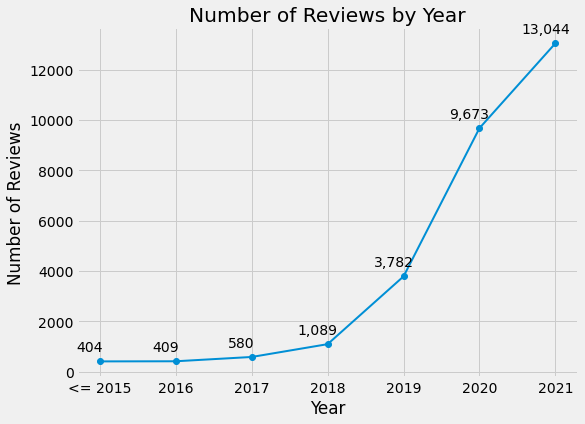

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

xn = range(reviews_yr.shape[0])
ax = plt.plot( xn, reviews_yr['number of reviews'], marker='o', linewidth=2)
plt.xticks(xn, reviews_yr.year)
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

plt.title('Number of Reviews by Year')

# source: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
for x,y in zip(xn,reviews_yr['number of reviews']):

    label = "{:,}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

We have just 404 reviews before 2016. Customers' feedback about applications really picked up in 2018. In 2019, the number reached to a respectable level of 3800 reviews. Growth continues in 2020 & 2021. __We will not consider the reviews prior to & including 2018 year__ because
1. Numbers are less.
2. Mobile application improvements happen much faster.
3. Those are initial development and adaptation years and may be lacking in maturity.

** 2021 is as of 26 Aug 2021.

In [25]:
df_reviews = df_reviews.loc[df_reviews.year > 2018,]
df_reviews = df_reviews.drop(columns=['bin_years'])
print('Number of records : {}'.format(df_reviews.shape[0]))
df_reviews.company.value_counts()

Number of records : 26499


HDFC ERGO           7097
Bajaj Allianz       6239
ICICI Lombard       4624
Acko                4219
Reliance General    2760
Iffco Tokio          688
Navi                 459
Digit                413
Name: company, dtype: int64

HDFC Ergo, Bajaj Allianz have >6000 reviews. IFFCO Tokio which is 4th largest has just 688 reviews.  
Acko has 2400 reviews while other insurtechs digits & navi have 400-450 reviews.

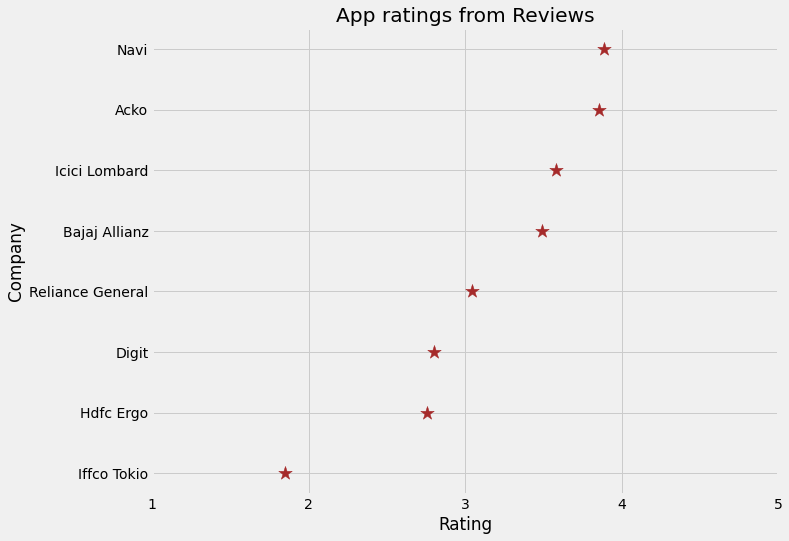

In [26]:
df_review_summary = df_reviews.groupby('company').agg(
                                avg_score = ('score',np.mean),
                                score_counts = ('score', 'count'))
df_review_summary = df_review_summary.sort_values(by='avg_score')

# Draw plot
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y=df_review_summary.index, x=df_review_summary.avg_score, s=200, color='brown', marker = '*')

# Title, Label, Ticks and Ylim
ax.set_title('App ratings from Reviews')
ax.set_xlabel('Rating')
ax.set_ylabel('Company')
ax.set_yticks(df_review_summary.index)
ax.set_yticklabels(df_review_summary.index.str.title(), fontdict={'horizontalalignment': 'right'})

# Customizing X axis ticks
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5])
ax.set_xlim(1, 5)
plt.show()

Navi & Acko are leaders with ~3.8 stars. ICIC Lombard & Bajaj Allianz score ~3.5 stars. These GI companies are adopting & making good progress in the mobile application channel. Digit & HDFC Ergo are at 2.8 stars & need to catch up with the leaders. IFFCO Tokio is a laggard with just 1.9 stars. 

Let's look at the distribution of ratings.

In [27]:
df_review_ratings = df_reviews.pivot_table(index='company', columns=['score'], 
                                           values='reviewId', aggfunc='count').fillna(value=0)

df_reviews_total = pd.DataFrame(df_review_ratings.sum(axis=0))
df_reviews_total.columns = ['Total']

print('Total Reviews by Ratings')
print(df_reviews_total.T)

Total Reviews by Ratings
score     1    2    3     4      5
Total  9666  892  931  2541  12469


In [28]:
df_review_ratings = df_review_ratings.append(df_reviews_total.T)

# Get the % in each rating value
df_review_ratings = df_review_ratings.div(df_review_ratings.sum(axis=1), axis=0)*100

In [29]:
company_subset_rank = ['Navi', 'Acko', 'ICICI Lombard', 'Bajaj Allianz', 'Reliance General',
                      'Digit','HDFC ERGO', 'Iffco Tokio','Total']

In [30]:
df_review_ratings = df_review_ratings.loc[company_subset_rank]

In [113]:
def plot_score_dist(df_review_ratings, figsize = (8,10)):
    """
    Dunction to plot 1-5 score rating distributionby companies
    
    df_review_ratings : dataframe containing company name as index & % ratings for each score as columns
    eg
    
    score     1    2    3     4      5
    company   30   10   15    20     65
    
    """
    
    
    labels = list(df_review_ratings.index)
    data = df_review_ratings.to_numpy()
    data_cum = data.cumsum(axis=1)

    category_names = ['v. poor', 'poor', 'average', 'good', 'excellent']

    category_colors = plt.get_cmap('RdYlBu')(
            np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=figsize)
    ax.invert_yaxis()
    ax.grid(False)
    ax.xaxis.set_visible(False)

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center', size = 'medium',
                    color=text_color)

    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium',
              columnspacing = 1, handletextpad=0.2)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.title('Rating Distribution by Company', pad=60)
    plt.ylabel('Company')
    plt.show()


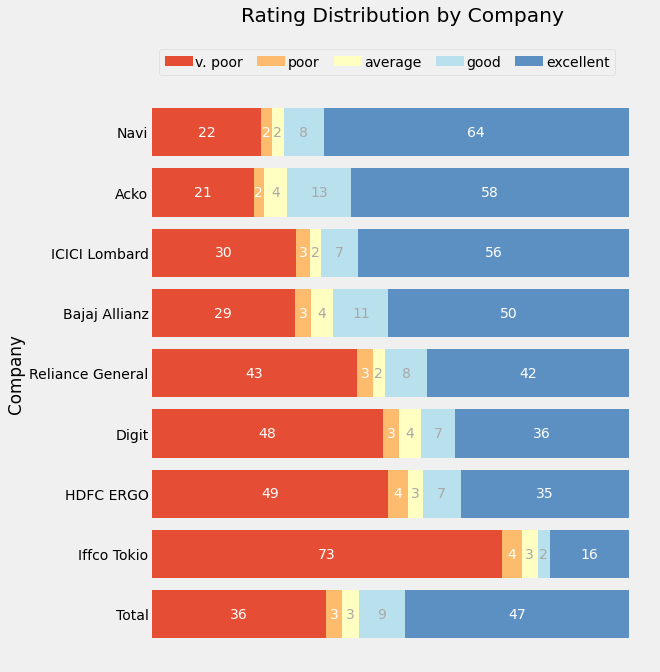

In [114]:
plot_score_dist(df_review_ratings)

Navi has highest i.e. 64% 5 star reviews. Acko & ICICI Lombard are next with 58% & 56% 5 star ratings. Yet these companies have a 20-30% 1 star rating for apps. This indicates a huge scope of improvement even for leaders. IFFCO Tokio has a 73% 1 star rating and is an outlier. Digit, HDFC Ergo & Reliance have 40-50% reviews with just 1 star rating.
 
Overall, we have a highly polarized dataset. __~80%__ of the reviewers have given either __Excellent or Very Poor__ rating. Only about 3% reviewers are neutral. We group the ratings as per below logic   
1. combine 4 & 5 as positive and label them as 0
2. combine 1 & 2 as negative and label them as 1
3. ignore 3

In [33]:
df_reviews = df_reviews.loc[df_reviews.score != 3,:]

print('{} neutral records removed'.format(df_reviews_total.loc[3].values))

df_reviews['rating'] = np.where(df_reviews.score <=2, 1, 0)

rating_dist = df_reviews.rating.value_counts().rename_axis('sentiment').reset_index(name='counts')
print('Distribution of Positive(0) and Negative(1) sentiments')
rating_dist.sentiment = rating_dist.sentiment.map({0:'Positive', 1:'Negative'})
rating_dist

[931] neutral records removed
Distribution of Positive(0) and Negative(1) sentiments


,sentiment,counts
0,Positive,15010
1,Negative,10558


In [34]:
print('After removing pre 2019 reviews and selecting Top 5 GIs & 3 InsurTechs,')
print('we finally have {} ({:.2%}) records'.format(df_reviews.shape[0],df_reviews.shape[0]/df_reviews_all.shape[0]))

After removing pre 2019 reviews and selecting Top 5 GIs & 3 InsurTechs,
we finally have 25568 (82.10%) records


In [35]:
company_dist = df_reviews.company.value_counts().rename_axis('Company').reset_index(name='Reviews')
company_dist

,Company,Reviews
0,HDFC ERGO,6882
1,Bajaj Allianz,5949
2,ICICI Lombard,4523
3,Acko,4016
4,Reliance General,2692
5,Iffco Tokio,665
6,Navi,447
7,Digit,394


In [36]:
def count_words(text):
    tokens = word_tokenize(text)
    return len(tokens)

count_words('Hi there :) !')

5

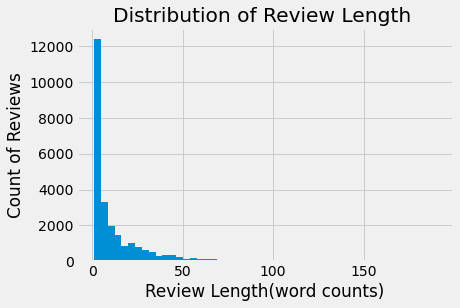

In [37]:
review_len = df_reviews.review.apply(count_words)
plt.hist(review_len, bins=50)
plt.title('Distribution of Review Length ')
plt.xlabel('Review Length(word counts)')
plt.ylabel('Count of Reviews')
plt.show();

In [38]:
review_len.describe(percentiles=[0.25, .50, 0.75, 0.875,.95])

count    25568.000000
mean        13.175845
std         19.095722
min          1.000000
25%          2.000000
50%          5.000000
75%         17.000000
87.5%       31.000000
95%         54.000000
max        190.000000
Name: review, dtype: float64

We have a highly skewed distribution. 50% of the reviews are having less than 5 words while top 5 percentile reviews are greater than 54 words in length. Longest review has 190 words.  

Let us look at some short & long sample reviews.

In [39]:
def print_reviews(review_length=5, n = 30):
    df_rv_len = df_reviews.loc[review_len==review_length,'review']
    print('{} Reviews with lenght {}'.format(len(df_rv_len),review_length))
    print('They are: \n', df_rv_len.sample(n).values)

In [40]:
print_reviews(review_length=1)

5728 Reviews with lenght 1
They are: 
 ['Excellent' 'fine' 'Good' 'nik' 'good' 'Good' 'good' 'Best' 'good' 'good'
 'Good' 'nice' 'Nice' 'Good' 'goodwork' 'Gud' 'Awesome' 'good' 'Good'
 'later' 'Good' 'Good' 'Good' 'Nice' 'Better' 'Nice' 'Good' 'Easy' 'Bad'
 'good']


In [41]:
print_reviews(review_length=2)

3706 Reviews with lenght 2
They are: 
 ['Very good' 'bad app' 'Very useful' 'Bad service' 'Nice app'
 'excellent experience' 'bad service' 'Good experience' 'Everything hangs'
 'Fantastic Nice' 'Great app' 'Super app' 'very good' 'Good Experience'
 'Very good' 'Nice App' 'Fantastic app' 'Very useful' 'Very helpful'
 'Very nice' 'Very Good' 'Veary Good' 'Best service' 'Good Service'
 'Nice app' 'Very bad' 'Fantastic service' 'Nice apps' 'Sakina begum'
 'West app']


In [42]:
print_reviews(review_length=3)

1841 Reviews with lenght 3
They are: 
 ['Lovely Applications 👍👍👍' 'best application.' 'Very good app'
 'Overall good experience' 'Nice app.' 'Really Nice app'
 'Handy to operate' '1 time good' 'Very Friendly app' 'well done 👍'
 'Best Services provided' 'Very good...' 'Awesome app!' 'good to use'
 'Very useful.' 'Very good app' 'free diamond 💎💎💎' 'Need more improve'
 'Very good app' 'Wonderful App!' 'Good application Nhea' 'Very slow app'
 'Renewals made easy' 'App not useful' 'Unbale to use' 'Nice :)'
 'Bakbash h app' 'New to this' 'Good and silent' 'Simply superb.']


In [43]:
print_reviews(review_length=4)

1114 Reviews with lenght 4
They are: 
 ['Not showing my policy' 'Very easy to access' 'Best answer net policy'
 'Worst app ever made' 'Good very easy function' 'Best me sabse best'
 'Fantastic app like it' 'Not so much good' 'Good response by team'
 'App is very slow' 'most disgusting app....' 'Khatiya app hai bakwas'
 'Good app and provision' 'Worthless waste of time' 'Very handy to use'
 'Ilike the app easy' 'Very nice so good' 'One type of dustbin'
 'help us with me' 'Good And Need Improvement' 'Pooja app achha lga'
 'this app very much' 'Super app...❤️❤️❤️❤️' 'Not working properly,'
 'Details not getting fetched' 'Your service very poor'
 'Good Policy App..' 'Excellent app and service' "Doesn't even open"
 "It doesn't work"]


In [44]:
print_reviews(review_length=5)

1047 Reviews with lenght 5
They are: 
 ['User friendly. Smooth.' 'Good application...Thanks neha'
 'Not at all user friendly' 'need to update engine/charsee number'
 'Best option in covid19 time' 'Very easy to book online'
 'Ease of update and use' 'No information will update......'
 'Hello doctor service is awesome' 'Easy transaction , super app'
 'Pathetic app .. nothing works' 'Seamless and easy to use'
 'After update it works well' 'New version is great.'
 'Unable to link my policy' 'Not responding very worst update'
 'Worst app and worst service' 'Very nice and customer friendly'
 'Amazing Service !!!' 'Good app and good service'
 'application is functioning seamlessly.' 'VERY GOOD AND FAST APP'
 'Very good guidence from Nehal' 'IL hello dr is good'
 'Very Helpfull app Thank you' 'Keep it up HDFC ERGO'
 'User friendly, easy process' 'Excellent app good job 😊'
 'Worst app and worst service' 'Easy settlement done by me']


In [45]:
print_reviews(review_length=6)

907 Reviews with lenght 6
They are: 
 ['We can upload claim documents easily'
 'Worst COMPANY ........giving minus star'
 'Very poor servicer after buy policy' 'Best one you come with app'
 'Lun* se bura aap hai' 'Worst experience in renewal process...'
 'Bad experience customer care no option'
 'Very slow. Always showing loading' 'Good and easy to pay insurance'
 'Good and quick to login 👍' 'VERY GOOD POLICY. I LIKED'
 'Smooth ride , Super fast 👌' 'No renewal facility on this app'
 'Very nice auto corrects mistake ⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐'
 'Bad app, showing wrong info' 'App is very slow and unresponsive'
 'Excellent 👌 Excellent 👌 Excellent.'
 'Unable to download and renew policy' 'Best app for our policy detail'
 'Good Quick service response for claims' 'very very easy, must try'
 'App makes claims process simpler.'
 'deleting my feedback..... worst service'
 'Bakwas app always show expired policy'
 'Very good service and user friendly' 'Very nice services fast and easy'
 'Very difficult process o

In [46]:
biggest_reviews = df_reviews.loc[review_len==review_len.max(),'review']
print('{} Reviews with lenght {}'.format(len(biggest_reviews),review_len.max()))
print('They are: \n', biggest_reviews.values)

1 Reviews with lenght 190
They are: 
 ['The waste company i have been policy holder from past 9 years. i renew this policy every year i never felt need to use this policy but in this august i admitted for two days only and having 8000/- hospital expenses, when i register claim on website my sanction claim is only 5202 rupees they email me the list of claim report in that various type of deduction like investigation charges,nursing charges not covered, injection charges not covered, they mention some medicine name that also not covered, etc. when i ask to arrange the call for clarification of these things, i waiting for call last 4 days. I am the policy holder from last 9 years and my first claim is 8000/- but sanction amount is only 5202/- so friends think about this their executive sell the policy lots of benefit offer by them, but when you buy that all benefits comes under investigation that not informed when you buy that policy or by their executive. I am the foolish person who rene

### Reviews with less than 4 words are nothing but ratings. 

In [47]:
df_long_reviews = df_reviews.loc[review_len > 3,:].copy()
df_long_reviews.shape

(14293, 12)

In [48]:
map_sentiment = {0:'Positive', 1:'Negative'}

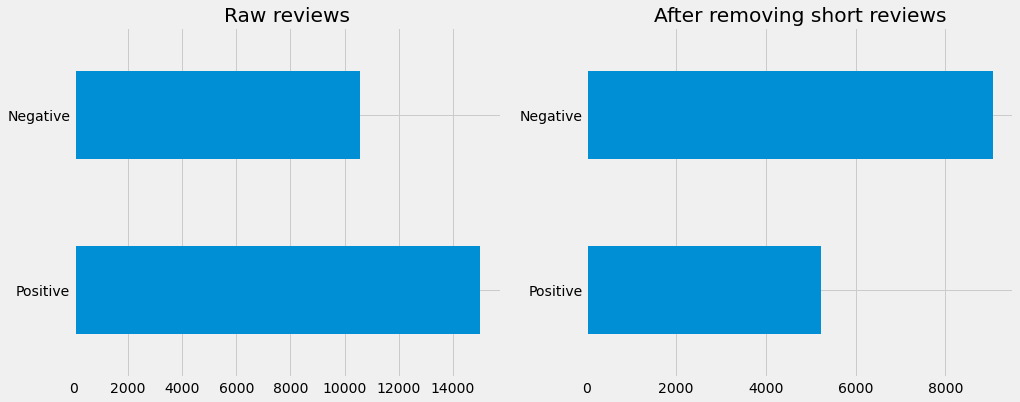

In [49]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax = df_reviews.rating.map(map_sentiment).value_counts().plot(kind='barh', ax= ax1, title = "Raw reviews")

ax2 = fig.add_subplot(122)
ax = df_long_reviews.rating.map(map_sentiment).value_counts().plot(kind='barh', ax= ax2, title = "After removing short reviews")
ax.invert_yaxis()


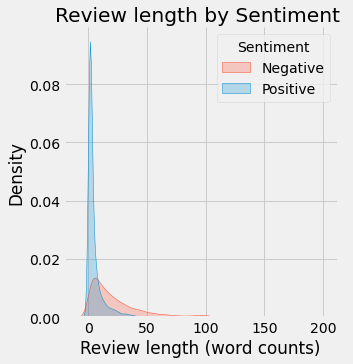

In [50]:
df_reviews['review_len'] = review_len
sns.displot(df_reviews, x="review_len", hue='rating', kind="kde",fill=True, legend=False)
plt.title('Review length by Sentiment ')
plt.xlabel('Review length (word counts)')
plt.legend(title='Sentiment', loc='upper right', labels=['Negative','Positive']);

Most of the deleted reviews belong to positive sentiments. This makes sense as many customers with Positive experience will write generic short reviews. Hence, these reviews are deleted. While with Negative sentiment, on an average, customers are more explicit and detailed about the problem they are facing.

In [51]:
company_dist_long = df_long_reviews.company.value_counts().rename_axis('Company').reset_index(name='Long Reviews')
company_dist_long = company_dist_long.merge(company_dist,on='Company')
company_dist_long


,Company,Long Reviews,Reviews
0,HDFC ERGO,4084,6882
1,ICICI Lombard,2957,4523
2,Bajaj Allianz,2762,5949
3,Acko,2011,4016
4,Reliance General,1535,2692
5,Iffco Tokio,491,665
6,Digit,273,394
7,Navi,180,447


Because of lack of credible data, we will do the analysis for below 4 companies.

In [52]:
top_3 = ['ICICI Lombard', 'Bajaj Allianz', 'HDFC ERGO']
insure_tech = ['Acko']
company_subset_long_review = top_3 + insure_tech
company_subset_long_review_ind  = df_long_reviews.company.isin(company_subset_long_review)

df_long_4 = df_long_reviews.loc[company_subset_long_review_ind,:].copy()
df_long_4.company.shape

(11814,)

We will continue with typical text data cleaning steps.

In [53]:
# Contractions
#source : https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [54]:
# Emoji
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, UNICODE_EMOJI[emot].replace(':', ' ').replace('_',' '))
        
    return text

In [55]:
# Emoticons
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot,EMOTICONS_EMO[emot])
    return text

In [56]:
# Lower
def convert_lower(text):
    return text.lower()

In [57]:
# Punctuations
def remove_punctuations(text):
    punct = string.punctuation
    pd_table = str.maketrans('', '', punct)
    text = text.translate(pd_table)
    return text

In [58]:
# Remove leading & trailing white spaces
def remove_whitespaces(text):
    text = text.strip()
    return text

In [59]:
def correct_spelling(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [60]:
# Tokenize
def wtokenize(text):
    
    text = word_tokenize(text)
    return text

In [61]:
brand_names = set(['icici','lombard','bajaj','allianz','alliance', 
               'hdfc','ergo', 'bank', 'iffco', 'tokio', 
               'reliance', 'acko', 'digit', 'navi', 'coco', 'apollo', 'munich'])

def remove_brand_names(text):
    
    tokens  = wtokenize(text)
    # text =  ' '.join([word if word not in brand_names else 'word_is_brandname' for word in tokens ])
    text =  ' '.join([word for word in tokens if word not in brand_names])
    return text

remove_brand_names('hdfc is best')

'is best'

In [62]:
def replace_application(text):
    word_app = ['application','applications']
    tokens  = wtokenize(text)
    text =  ' '.join([word if word not in word_app else 'app' for word in tokens ])
    return text      

replace_application('application hangs frequently')

'app hangs frequently'

In [63]:
def remove_non_alpha_numeric(text,keep_numeric=True):
    
    # [ ]: match any character inside the list defined by the square brackets, including the space character ' '
    # ^: Negation
    # A-Z: accept english upper case characters from A to Z
    # source : https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html
    
    ALPHA = r'[^a-zA-z\s]'
    ALPHA_NUMRIC = r'[^a-zA-z0-9\s]'
    if keep_numeric == True:
        PATTERN = ALPHA_NUMRIC
    else :
        PATTERN = ALPHA
        
    text = re.sub(PATTERN, '', text)
    return text


In [64]:
def remove_extra_whitespaces(text):
    
    text = re.sub(' +', ' ', text)
    return text

In [65]:
def preprocess_text(text):
    """
    Performs typical text data cleaning steps
    
    text : review text
    clean_text: text after perfroming all the cleaning steps 
    """
    
    rmv_lt_whitespace = remove_whitespaces(text)
    expanded = expand_contractions(rmv_lt_whitespace)
    deemojised = convert_emojis(expanded)
    cnvt_emoticons = convert_emoticons(deemojised)
    lower_txt = convert_lower(cnvt_emoticons)
    rmv_non_alpha_num = remove_non_alpha_numeric(lower_txt,keep_numeric=False) 
    rmv_brand = remove_brand_names(rmv_non_alpha_num)
    rpc_application = replace_application(rmv_brand)
    clean_text = remove_extra_whitespaces(rpc_application)
    
    return clean_text

Following reviews are created for testing based on general observations & likely scenarios.

In [66]:
fustrated_review = "Pathetic app, not at all user friendly, doesn't open, \
                takes too long for navigating from link/page to another ...  "
mistake_review = "Bad 1one time use after not working hangon please wait re install after use bad app cheat. \
                  please fit it 🤦🤦"
happy_review = " :) Superb App....      Now policy booking and claim intimation would brew much easier...\
                Network hospitals search its very handy! Kudos!👌 "
angry_review = " 😠 3rd class app by reliance. No response of our registration of policy and many more problems"
multi_lingual = "थर्ड class... धब्बा 'હમબડીયું.... Never buying again 😡 "

ppn_lingual = " super app. Neha explained it well and I was able to file the claims"

dummy_reviews = [fustrated_review, mistake_review, happy_review, angry_review, multi_lingual, ppn_lingual]
df_dummy_reviews = pd.DataFrame(dummy_reviews,columns=['reviews'])

In [67]:
df_dummy_reviews['preprocess_review']= df_dummy_reviews.reviews.apply(preprocess_text)

for review, preprocess_review in zip(df_dummy_reviews.reviews, df_dummy_reviews.preprocess_review):
    print('Raw review :', review)
    print('Processed review :', preprocess_review)
    print('\n')

Raw review : Pathetic app, not at all user friendly, doesn't open,                 takes too long for navigating from link/page to another ...  
Processed review : pathetic app not at all user friendly does not open takes too long for navigating from linkpage to another


Raw review : Bad 1one time use after not working hangon please wait re install after use bad app cheat.                   please fit it 🤦🤦
Processed review : bad one time use after not working hangon please wait re install after use bad app cheat please fit it person facepalming person facepalming


Raw review :  :) Superb App....      Now policy booking and claim intimation would brew much easier...                Network hospitals search its very handy! Kudos!👌 
Processed review : happy face or smiley superb app now policy booking and claim intimation would brew much easier network hospitals search its very handy kudos ok hand


Raw review :  😠 3rd class app by reliance. No response of our registration of policy and

In [68]:
df_long_4.head()

,reviewId,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,company,year,rating
0,gp:AOqpTOF86De47sxTLcSz5dRWRlYNfO2IN5pk3baCjf8...,Excellent.. The service and reaction were exce...,5,0,NaN,2021-08-26 22:29:04,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0
1,gp:AOqpTOH09z1vHSV2KRUcILU1eSsx-5HzWABJDC2pCW6...,"The app is simple and tidy, with a focus on th...",5,0,NaN,2021-08-26 22:28:35,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0
2,gp:AOqpTOGYmB7z6aIyAFtbD4YheqYzuDrtrQcYBBJSkmZ...,It is simple to select and purchase insurance....,5,0,NaN,2021-08-26 22:27:21,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0
3,gp:AOqpTOFEDySNZlgqJByDGyF8C8WMT6pJhqcgAhMokeI...,I've used this app for my car insurance a few ...,5,0,NaN,2021-08-26 22:26:59,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0
4,gp:AOqpTOFE6WGoCMTXBlT57sZBjZIxwH0zsmyBH8D2C14...,It is wrost insurance company . One of my frie...,1,0,2.0.40,2021-08-26 21:21:10,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,1


In [69]:
df_text = df_long_4.loc[:,['reviewId','review']].copy()

if development_flag == True:
    df_text = df_text.sample(100)

df_text.shape

(11814, 2)

In [70]:
%%timeit

df_text['preprocess_review']= df_text.review.apply(preprocess_text)

23.3 s ± 718 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
df_text['preprocess_review'].head(10)

0     excellent the service and reaction were excell...
1     the app is simple and tidy with a focus on the...
2     it is simple to select and purchase insurance ...
3     i have used this app for my car insurance a fe...
4     it is wrost insurance company one of my friend...
5     this app does not even work properly sometimes...
6     wrost insurance company i had too bad experien...
8            good it is useful tor everyone download it
10    trying to correct my data of birth since rd au...
12    maine apni bike ka insurance liya aur ab mri b...
Name: preprocess_review, dtype: object

In [72]:
# lemmatize
# https://spacy.io/usage/processing-pipelines#processing
# https://stackoverflow.com/questions/64741609/how-to-remove-names-of-people-in-corpus-using-python
# https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb

lemma_txt = []

for doc in nlp.pipe(df_text['preprocess_review'],  n_process=-1, batch_size=2000):
    txt = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in doc])
    lemma_txt.append(txt)


In [73]:
lemma_txt[:5]

['excellent the service and reaction be excellent please keep up the good work and do not let your customer down',
 'the app be simple and tidy with a focus on the need of the consumer this app make it simple to apply for their insurance policy this app be easy to use because of its feature',
 'it be simple to select and purchase insurance this app allow I to renew my bike insurance the procedure go off without a hitch',
 'I have use this app for my car insurance a few time now and have always receive excellent service the procedure be easy and straightforward',
 'it be wrost insurance company one of my friend abhishek gupta purchase motor insurance and when he claim insurance then the survey person say that singal alloy wheal do not claim in insurance why this this be wrost I suggest do not buy motor insurance']

In [74]:
# Stop words
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [75]:
# no & not can alter the meaning of the sentence. Hence, we will not treat these as stop words
stop_words.remove('no')
stop_words.remove('not')
# treating very as a stopword since we have a binary sentiment to predict & interprete.

# insurance is the product we are analyzing. Hence, adding it to stop word.
stop_words.append('insurance')

We are more interesting in understanding __what kind of application features or customer service are driving positive
or negative sentiments__. Interpretation is the primary objective here. Hence, we will remove below words which occur frequently but do not contribute to the objective much.

In [76]:
stop_words.extend(['good','bad','best','worst','nice','pathetic','excellent','great'])

In [77]:
def remove_stopwords(text):
    tokens  = wtokenize(text)
    text =  ' '.join([word for word in tokens if word.lower() not in stop_words])
    return text

In [78]:
# Remove stop words
clean_txt = []

for text in lemma_txt:
    rmv_stopwords = remove_stopwords(text)
    clean_txt.append(rmv_stopwords)

clean_txt[:10]

['service reaction please keep work not let customer',
 'app simple tidy focus need consumer app make simple apply policy app easy use feature',
 'simple select purchase app allow renew bike procedure go without hitch',
 'use app car time always receive service procedure easy straightforward',
 'wrost company one friend abhishek gupta purchase motor claim survey person say singal alloy wheal not claim wrost suggest not buy motor',
 'app not even work properly sometimes not even open totally waste app team manage product totally suck',
 'wrost company experienceduring policy give company tell big big profit claim disclose hidden charge company agent ask money complain also no one give answer cheater',
 'useful tor everyone download',
 'try correct datum birth since rd august request time accept request dob remain incorrect ask contact hr company not app not keep option',
 'maine apni bike ka liya aur ab mri bike road pr gadde ki hone ki wjh se accident uske back ka alloy wheal tut gya b

In [79]:
en_lang_ind = []

for text in clean_txt:
    if len(text) > 0 :
        lang = detect(text)
        en_lang_ind.append(lang=='en')
    else :
        en_lang_ind.append(True)

In [80]:
len(en_lang_ind) - sum(en_lang_ind)

2604

In [81]:
from itertools import compress

non_eng_ind = [not elem for elem in en_lang_ind]

list(compress(clean_txt, non_eng_ind))[::100]

['maine apni bike ka liya aur ab mri bike road pr gadde ki hone ki wjh se accident uske back ka alloy wheal tut gya bt servey krne wala person bolta h singal alloy wheal cliam nhi hoti pls sugget ka koi na krwaye inki koi custmore loyalti nhi h maine managaer ko call lgaya wo bolya h time hofa tb btayege wrost compnay motir',
 'video consultation user friendly',
 'app',
 'app esga use',
 'description representative rakesh',
 'policy detail relate coverage miss app',
 'error unable download stop',
 'unable add policy experience customer support',
 'use app',
 'help',
 'clean',
 'easy user friendly',
 'not work',
 'app app',
 'app de slow no use poor app',
 'open take long time',
 'take age install',
 'goodjust awesome',
 'app jab detail nahi update ki tab naya aap hi kyu banaya',
 'need develop compare app seem quite old version',
 'app insurer',
 'fantastic app manage one go much recommend',
 'app error everything hang middle hope resolve soon',
 'app no problem',
 'app spam call cross

Language detection perfroms poorly when text is short in length. Hence, we will not be using it.

In [82]:
df_text['clean_review'] = clean_txt
df_text.head()

,reviewId,review,preprocess_review,clean_review
0,gp:AOqpTOF86De47sxTLcSz5dRWRlYNfO2IN5pk3baCjf8...,Excellent.. The service and reaction were exce...,excellent the service and reaction were excell...,service reaction please keep work not let cust...
1,gp:AOqpTOH09z1vHSV2KRUcILU1eSsx-5HzWABJDC2pCW6...,"The app is simple and tidy, with a focus on th...",the app is simple and tidy with a focus on the...,app simple tidy focus need consumer app make s...
2,gp:AOqpTOGYmB7z6aIyAFtbD4YheqYzuDrtrQcYBBJSkmZ...,It is simple to select and purchase insurance....,it is simple to select and purchase insurance ...,simple select purchase app allow renew bike pr...
3,gp:AOqpTOFEDySNZlgqJByDGyF8C8WMT6pJhqcgAhMokeI...,I've used this app for my car insurance a few ...,i have used this app for my car insurance a fe...,use app car time always receive service proced...
4,gp:AOqpTOFE6WGoCMTXBlT57sZBjZIxwH0zsmyBH8D2C14...,It is wrost insurance company . One of my frie...,it is wrost insurance company one of my friend...,wrost company one friend abhishek gupta purcha...


In [83]:
df_long_4 = df_long_4.merge(df_text[['reviewId','clean_review']], on = ['reviewId'], how = 'left')
df_long_4.head()

,reviewId,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,company,year,rating,clean_review
0,gp:AOqpTOF86De47sxTLcSz5dRWRlYNfO2IN5pk3baCjf8...,Excellent.. The service and reaction were exce...,5,0,NaN,2021-08-26 22:29:04,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0,service reaction please keep work not let cust...
1,gp:AOqpTOH09z1vHSV2KRUcILU1eSsx-5HzWABJDC2pCW6...,"The app is simple and tidy, with a focus on th...",5,0,NaN,2021-08-26 22:28:35,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0,app simple tidy focus need consumer app make s...
2,gp:AOqpTOGYmB7z6aIyAFtbD4YheqYzuDrtrQcYBBJSkmZ...,It is simple to select and purchase insurance....,5,0,NaN,2021-08-26 22:27:21,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0,simple select purchase app allow renew bike pr...
3,gp:AOqpTOFEDySNZlgqJByDGyF8C8WMT6pJhqcgAhMokeI...,I've used this app for my car insurance a few ...,5,0,NaN,2021-08-26 22:26:59,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,0,use app car time always receive service proced...
4,gp:AOqpTOFE6WGoCMTXBlT57sZBjZIxwH0zsmyBH8D2C14...,It is wrost insurance company . One of my frie...,1,0,2.0.40,2021-08-26 21:21:10,NaN,NaT,icici.lombard.ghi,ICICI Lombard,2021,1,wrost company one friend abhishek gupta purcha...


In [84]:
# df_reviews = df_reviews.rename(columns= {'clean_review_y':'clean_review'})

In [85]:
df_long_4.clean_review.isna().sum()

0

In [86]:
df_long_4['clean_review_len'] = df_long_4.clean_review.apply(count_words)

In [87]:
def display_reviews(review_length = 1, top_n = 10):
    
    df =  df_long_4.loc[df_long_4.clean_review_len==review_length,['review','clean_review']]
    print('{} reviews with length {}: '.format(df.shape[0],review_length))
    
    df_top_n = df.clean_review.value_counts().rename_axis('clean_review').reset_index(name='counts').head(top_n)
    print('Top {} sums to {:d} '.format(top_n, df_top_n.counts.sum()))
    print(df_top_n.clean_review.values)
    return None

display_reviews(0)

74 reviews with length 0: 
Top 10 sums to 74 
['']


In [88]:
df_long_4.loc[df_long_4.clean_review_len ==0 , 'review'].sample(10)

4927                                     Very good and the
4568     मेरा क्लेम के लिए लटका रखा है ना पास करते हैं ...
3989                            હમબડીયું સે લંબાડીયા જેવું
10724    इन को गाली देने का मन करता है acko के कस्टमर क...
9311                                       It is very good
7983     यह सिर्फ पॉलिसी बेचते वक्त बड़ी मीठी मीठी बाते...
11139    फ़ोन रिपेयर हो जाने के बाद भी 2-3 दिन डिलीवरी क...
8824     अतिशय चांगल्या प्रकारची सेवा इन्शुरन्स कंपनीकड...
11580              अच्छी कंपनी है बीमा आसानी से हो जाता है
9609                  It's good ..........................
Name: review, dtype: object

Sample reviews which were removed in the cleaning process. We can see just stop words, non-English reviews.

In [89]:
display_reviews(review_length=1,top_n=100)

269 reviews with length 1: 
Top 100 sums to 269 
['app' 'service' 'experience' 'easy' 'work' 'use' 'company' 'thank'
 'useful' 'helpful' 'job' 'far' 'policy' 'fast' 'nehal' 'simple' 'poor'
 'convenient' 'slow' 'performance' 'like' 'keep' 'love' 'operate' 'help'
 'ok' 'well' 'information' 'intiative' 'wowsuper' 'always' 'aap'
 'healthjinn' 'quick' 'never' 'ui' 'idv' 'healpful' 'competetive'
 'nicetill' 'buy' 'fastly' 'hopeless' 'one' 'instal' 'important' 'appkeep'
 'clean' 'l' 'dinesh' 'informative' 'superb' 'betterb' 'really' 'budget'
 'since' 'expireanc' 'not' 'faith' 'request' 'price' 'pathentic' 'core'
 'family' 'extremely' 'claim' 'stick' 'user' 'customer' 'appslow' 'co'
 'load' 'accessible' 'polocy' 'otp' 'happy' 'system' 'convention'
 'excellentinstantfast' 'helpfulapp' 'convinient' 'excellentvary'
 'harshala' 'rakesh' 'time' 'servicethank' 'improve' 'experiance'
 'friendly' 'future' 'hang' 'enough' 'initiative' 'pnb']


In [90]:
display_reviews(review_length=2,top_n=100)

831 reviews with length 2: 
Top 100 sums to 360 
['easy use' 'app service' 'not work' 'useful app' 'user friendly'
 'app useful' 'app helpful' 'easy app' 'easy access' 'slow app'
 'service app' 'easy operate' 'app thank' 'app slow' 'fast easy' 'one app'
 'app policy' 'easy convenient' 'app thumb' 'wonderful app'
 'experience app' 'love app' 'app use' 'service thank' 'easy handle'
 'keep load' 'simple use' 'helpful app' 'easy fast' 'quick easy'
 'fast service' 'app load' 'superb app' 'convenient app' 'supportive app'
 'poor service' 'service give' 'experience service' 'awesome experience'
 'use app' 'easy claim' 'one useful' 'app customer' 'user interface'
 'app work' 'easy simple' 'easy pay' 'two wheeler' 'easy cheap' 'app ever'
 'app mohd' 'app download' 'app working' 'fast processing' 'service thumb'
 'customer service' 'aap useful' 'unable register' 'app claim' 'not open'
 'poor slow' 'poor app' 'slow performance' 'fraud company'
 'health company' 'wow easy' 'till experience' 'app a

In [91]:
display_reviews(review_length=3,top_n=100)

1221 reviews with length 3: 
Top 100 sums to 283 
['app not work' 'app easy use' 'user friendly app' 'easy use app'
 'unable link policy' 'app user friendly' 'app thank neha'
 'not work properly' 'app not open' 'policy not show' 'app easy access'
 'not user friendly' 'unable renew policy' 'app ever see'
 'unable install app' 'simple user friendly' 'hello doctor service'
 'loading loading loading' 'not get otp' 'easy user friendly'
 'not able login' 'third class app' 'fast user friendly' 'not link policy'
 'useful app thumb' 'app ever use' 'not open app' 'app easy work'
 'useless app slow' 'experience hassle free' 'not show policy'
 'policy one app' 'app no use' 'convenient easy use' 'not fetch policy'
 'wrost app slow' 'hassle free renewal' 'app easy handle' 'app keep load'
 'not renew policy' 'unable add policy' 'app not respond'
 'easy register claim' 'app ok hand' 'not work app' 'easy buy policy'
 'use full app' 'app play store' 'app guide nehal' 'simple easy use'
 'easy use thank' 

In [92]:
display_reviews(review_length=4,top_n=50)

1089 reviews with length 4: 
Top 50 sums to 85 
['app not work properly' 'not able link policy' 'not get otp log'
 'unable link health policy' 'claim not getting submit'
 'app hello doctor service' 'not get otp register'
 'user friendly app service' 'easy user friendly app'
 'not able download app' 'policy not show app' 'app not user friendly'
 'unable link policy app' 'otp not receive login' 'pdf upload not work'
 'third class app slow' 'renew policy not work' 'app not even open'
 'unable open app update' 'il hello doctor service'
 'easy use applicationthank neha' 'update app not open'
 'app waist not active' 'app slow loading datum' 'app always wait upload'
 'second time let see' 'work il communication representative'
 'superb app keep update' 'khatiya app hai bakwa' 'app check claim status'
 'bestin every aspect thank' 'pls give claim no' 'please make add free'
 'trusted use last year' 'nothing work app experience'
 'truly appreciate app support' 'app thank pooja ji'
 'app easy load

Reviews with 1 word are ratings. 2 words reviews are not much informative and variety is less. Top 100 contribute to 45% of total 2 words reviews. From reviews with 3 words, we see information about customer's experience with app and the product. The variety also increases as top 100 contribute to 20% of total 3 words reviews. The infromation from these can be as general as 
1. easy fast app
2. app not working

Or it can be specific like 
1. unable download policy
2. easy register claim 

Hene, we will ignore reviews with length 1 & 2.

In [93]:
word_len_threshold = 3
df_review_cln = df_long_4.loc[df_long_4.clean_review_len >= word_len_threshold, :].copy()
df_review_cln.clean_review_len.min()

3

In [94]:
df_review_cln.shape

(10640, 14)

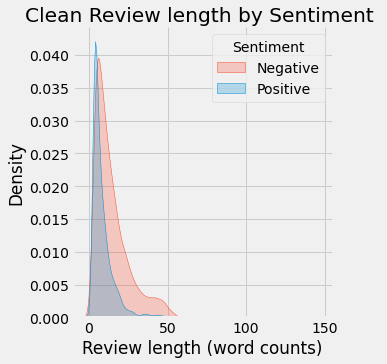

In [95]:
sns.displot(df_review_cln, x="clean_review_len", hue='rating', kind="kde",fill=True, legend=False)
plt.title('Clean Review length by Sentiment ')
plt.xlabel('Review length (word counts)')

plt.legend(title='Sentiment', loc='upper right', labels=['Negative','Positive']);

After all the data cleaning, we are left with 10675 quality reviews. Distribution dissimilarity is greatly reduced.

Let us look at the distribution of reviews by company and sentiment before & after data cleaning. 

In [96]:
company_dist = df_review_cln.company.value_counts().rename_axis('Company').reset_index(name='Reviews')

company_dist

,Company,Reviews
0,HDFC ERGO,3754
1,ICICI Lombard,2711
2,Bajaj Allianz,2431
3,Acko,1744


In [97]:
df_reviews_subset = df_reviews.loc[df_reviews.company.isin(company_subset_long_review),].copy()
df_reviews_subset_grp = df_reviews_subset.groupby(['company']).agg({'review':'count','rating':np.mean}).reset_index()

df_reviews_subset_grp = df_reviews_subset_grp.append({'company':'total',
                              'rating':df_reviews_subset.rating.mean(),
                              'review':df_reviews_subset.review.count()},ignore_index=True)

df_reviews_subset_grp['stage'] = 'Raw'
df_reviews_subset_grp = df_reviews_subset_grp.rename(columns={'rating':'Negative %'})
df_reviews_subset_grp

,company,review,Negative %,stage
0,Acko,4016,0.246763,Raw
1,Bajaj Allianz,5949,0.349639,Raw
2,HDFC ERGO,6882,0.554054,Raw
3,ICICI Lombard,4523,0.339377,Raw
4,total,21370,0.393964,Raw


In [98]:
df_review_cln_grp = df_review_cln.groupby(['company']).agg({'review':'count','rating':np.mean}).reset_index()

df_review_cln_grp = df_review_cln_grp.append({'company':'total',
                              'rating':df_review_cln.rating.mean(),
                              'review':df_review_cln.review.count()},ignore_index=True)


df_review_cln_grp['stage'] = 'Cleaned'
df_review_cln_grp = df_review_cln_grp.rename(columns={'rating':'Negative %'})

In [99]:
df_company_grp = pd.concat([df_reviews_subset_grp,df_review_cln_grp])
df_company_grp

,company,review,Negative %,stage
0,Acko,4016,0.246763,Raw
1,Bajaj Allianz,5949,0.349639,Raw
2,HDFC ERGO,6882,0.554054,Raw
3,ICICI Lombard,4523,0.339377,Raw
4,total,21370,0.393964,Raw
0,Acko,1744,0.467890,Cleaned
1,Bajaj Allianz,2431,0.677499,Cleaned
2,HDFC ERGO,3754,0.855354,Cleaned
3,ICICI Lombard,2711,0.493545,Cleaned
4,total,10640,0.659023,Cleaned


In [100]:
# To plot categorical featues.
# We plot categories on x-axis, default rate on primary y-axis & number of observations on secondary y axis.
# Plotting number of observations indicated the credibility of default rate.
def compare_company_dist(df, company, company_name):
    """
    Plots % Negative reviews and review counts before vs after data cleaning
    
    df - DataFrame
    company - Name of the company to analyze as per appId & company mapping
    company_name - Company name to display
    """
    df_company = df.loc[df.company==company,:]
    
    with plt.style.context('bmh'):
    
        # plotting default rate on primary y-axis
        fig, ax = plt.subplots(figsize=(9,6))
        fontsize = 15
        # Increase the size of graph when we have more than 4 categories
        ax.plot(df_company['stage'], df_company['Negative %'], 'o--', color= 'red',alpha=0.6)
        # Add value labels for dafault rates
        #source : https://stackoverflow.com/questions/59143306/add-label-values-to-bar-chart-and-line-chart-in-matplotlib
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.1%}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, 5), textcoords="offset points",
                        fontsize=fontsize,color = 'red',ha='center', va='bottom') 
            
        ax.set_title('Negative Review %  - ' + company_name, pad=25)
        ax.set_ylabel('Negative %')
        ax.set_xlabel('Processing')
        
        # setting the y-axis limit
        ax.set_ylim(ymin=0,ymax=df_company['Negative %'].max()+0.05)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        # plotting count of records on secondary y-axis
        ax2 = plt.twinx()
        ax2.bar(df_company['stage'], df_company['review'],
                    alpha=0.3, color='sandybrown')
        ax2.set_ylabel('Review Counts')
        ax2.grid(False)
        
        # Add legends for both y axes
        # source: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        # https://mpltest2.readthedocs.io/en/stable/gallery/recipes/transparent_legends.html
        fig.legend(labels=('Negative % ','Counts'),loc='upper right',bbox_to_anchor=(1,0.9),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.4)
        sns.despine(left=True,bottom=True,)
        plt.tight_layout()
        #plt.savefig(p / (company+'.pdf') )
        plt.show();


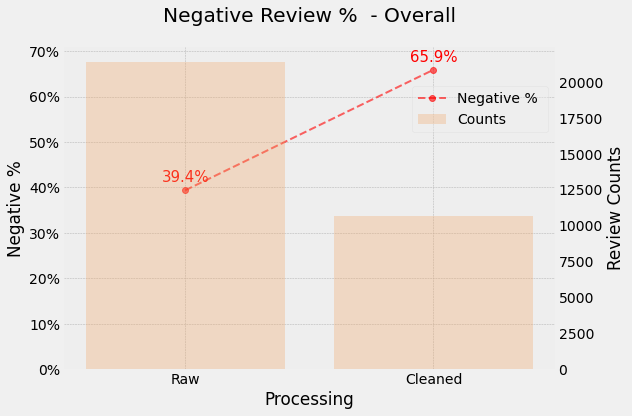

In [101]:
compare_company_dist(df_company_grp, 'total', 'Overall')

We have deleted ~50% of the reviews (from 21370 to 10640). Most of the deleted reviews were of positive sentiments. This makes sense as many customers with positive experience would write short reviews with generic words. Hence, these reviews are deleted in data cleaning. The net effect is % of Negative ratings increase by 67%.

This has essentially reversed the majority class from positive to negative sentiment. Our main objective is to find what is driving the negative sentiments. Hence, it is OK if the probability of negative reviews changes. The positive reviews which are removed are sparse and do not contain useful information.

We observe the same effect of increase in Negative ratings ranging from 48% to 100% across different companies as seen below.

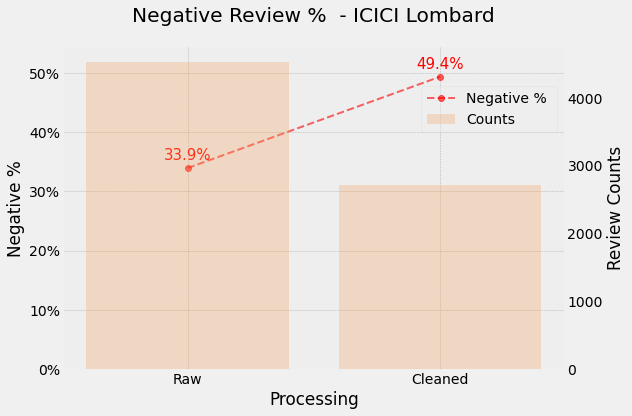

In [102]:
compare_company_dist(df_company_grp, 'ICICI Lombard', 'ICICI Lombard')

Negative review % increase by 48% and review counts decrease to 60%.

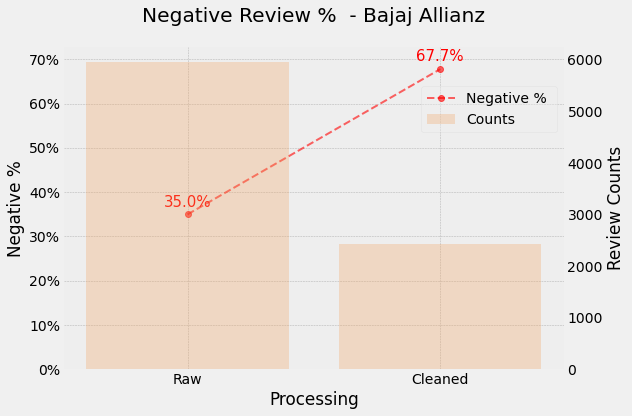

In [103]:
compare_company_dist(df_company_grp, 'Bajaj Allianz', 'Bajaj Allianz')

Negative reviews % increase by ~100% and review counts decrease to 40%.

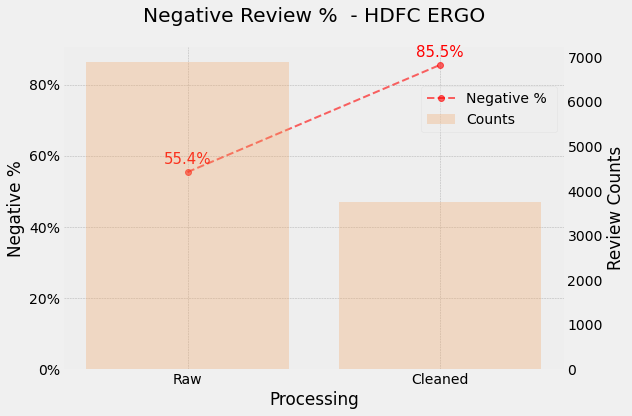

In [104]:
compare_company_dist(df_company_grp, 'HDFC ERGO', 'HDFC ERGO')

Negative reviews % increase by 54% and review counts decrease to 55%.

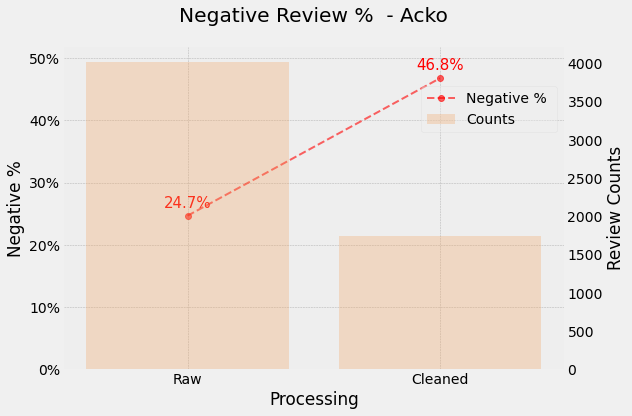

In [105]:
compare_company_dist(df_company_grp, 'Acko', 'Acko')

Negative reviews % increase by 90% and review counts decrease to 40%.

This completes the data cleaning step and now we will save the data for EDA in next step.

In [106]:
clean_review = '../data/interim/clean_review.csv'
df_review_cln.to_csv(clean_review,  index=None, header=True)

The process flow in this notebook is inspired from below sources

https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing

https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb


### For presentation

In [107]:
company_subset_rank_ppt = ['Acko', 'ICICI Lombard', 'Bajaj Allianz', 'HDFC ERGO',]

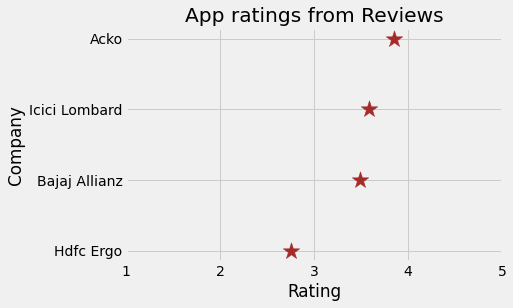

In [111]:
df_review_summary_ppt = df_review_summary.loc[company_subset_rank_ppt,]

# Draw plot
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y=df_review_summary_ppt.index, x=df_review_summary_ppt.avg_score, s=300, color='brown', marker = '*')

# Title, Label, Ticks and Ylim
ax.set_title('App ratings from Reviews')
ax.set_xlabel('Rating')
ax.set_ylabel('Company')
ax.set_yticks(df_review_summary_ppt.index)
ax.set_yticklabels(df_review_summary_ppt.index.str.title(), fontdict={'horizontalalignment': 'right'})
ax.invert_yaxis()

# Customizing X axis ticks
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5])
ax.set_xlim(1, 5)
plt.show()

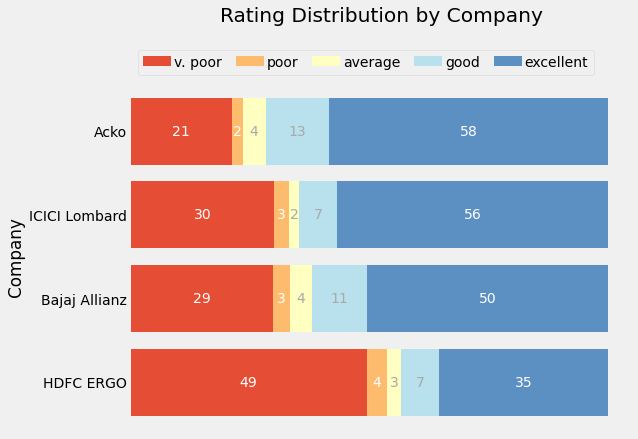

In [117]:
df_review_ratings_ppt = df_review_ratings.loc[company_subset_rank_ppt]

plot_score_dist(df_review_ratings_ppt, figsize=(8,6))